### Read in Data

1. Dataset Overview
audio_features: Shows individual arrays of numerical features as strings. This is expected at this stage, as you haven’t yet converted these to actual numerical arrays.
model_type: All rows belong to one type (A). This may suggest a lack of diversity in the model_type column, which might not be useful for classification if it doesn’t vary.
maneuvering_direction: Contains six unique values (e.g., R, CC, C), representing directions such as Right, Counter-Clockwise, and so on.
fault: Contains nine unique values (e.g., PC3, MF3).
2. Column Statistics
Count: Every column has 64,800 non-null entries, so there are no missing values. This is great for training machine learning models.
Unique:
audio_features: 64,800 unique rows, meaning no duplicate audio feature data.
model_type: Only one unique value (A), which makes it unsuitable for classification. You may need to ignore this column unless your dataset changes.
maneuvering_direction and fault: These have a manageable number of unique categories for classification tasks.
Top/Freq:
Indicates the most common values (top) and their frequencies (freq). For instance:
maneuvering_direction → R is the most frequent with 10,800 entries.
fault → PC3 is the most frequent with 7,200 entries.

In [1]:
import pandas as pd

# Load the dataset
file_path = 'Data.csv'  # Update with the actual file path
data = pd.read_csv(file_path)

# Verify that all rows have the same label for `model_type`
unique_labels = data['model_type'].unique()

if len(unique_labels) == 1:
    # If there's only one unique label, no machine learning is needed
    default_label = unique_labels[0]
    print(f"All rows have the same label: '{default_label}'.")
    print("Machine learning is unnecessary. Predictions will always be the same.")

    # Define a simple prediction function
    def predict_model_type():
        return default_label

    # Example usage
    print("Prediction for any input:", predict_model_type())

else:
    # Placeholder for ML training logic if multiple labels exist
    print("Dataset contains multiple labels. Proceeding with machine learning...")

All rows have the same label: 'A'.
Machine learning is unnecessary. Predictions will always be the same.
Prediction for any input: A


### Convert the audio column and extract features and labels
Explanation of the Output
Feature Matrix (X):

Shape: (64800, 40)
64800: The number of samples (rows) in your dataset.
40: The number of features (columns) in each audio_features array. This is consistent with your dataset's structure, where each sample's audio features are represented as a 40-dimensional array.
Model Labels (y_model):

Shape: (64800,)
This is a 1D array with one label for each of the 64,800 samples, corresponding to the drone's model_type.
Maneuvering Labels (y_maneuver):

Shape: (64800,)
Similarly, this is a 1D array with one label per sample, describing the maneuvering_direction (e.g., R, CC, C).
Fault Labels (y_fault):

Shape: (64800,)
This 1D array contains the fault types for each sample (e.g., PC3, MF3).

In [2]:
import numpy as np
# This method converts the audio column into a useable array
def parse_audio_features(feature_string):
    #Strips brackets and converts string to array
    return np.fromstring(feature_string.strip('[]'), sep=' ')

# Apply the function to all rows in the audio_features column
data['audio_features'] = data['audio_features'].apply(parse_audio_features)

# Separate features (X) and labels (y) for different classification tasks
# Extract the audio features into a feature matrix (X)
X = np.stack(data['audio_features'].values)

# Extract labels for classification tasks
y_model = data['model_type']                # Drone model classification
y_maneuver = data['maneuvering_direction']  # Maneuvering direction classification
y_fault = data['fault']                     # Fault detection classification

# Print the shapes of the feature matrix and label arrays for verification
print("Feature Matrix (X):", X.shape)
print("Model Labels (y_model):", y_model.shape)
print("Maneuvering Labels (y_maneuver):", y_maneuver.shape)
print("Fault Labels (y_fault):", y_fault.shape)

Feature Matrix (X): (64800, 40)
Model Labels (y_model): (64800,)
Maneuvering Labels (y_maneuver): (64800,)
Fault Labels (y_fault): (64800,)


### Data Splitting
The 80/20 split is a commonly used ratio in machine learning for dividing a dataset into training and testing subsets. With 20% testing data, you generally have enough samples to reliably measure metrics like accuracy, precision, recall, and F1-score.

In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/path/to/your/Data.csv'  # Update with the actual file path
data = pd.read_csv(file_path)

# Function to check if a column has only one unique value
def check_single_value_column(column):
    unique_values = data[column].unique()
    if len(unique_values) == 1:
        print(f"Column '{column}' has only one unique value: {unique_values[0]}. Skipping training for this column.")
        return True
    return False

# Define the columns to check
columns_to_check = ['model_type', 'maneuvering_direction', 'fault']

# Iterate through columns and only proceed with training if multiple labels exist
for target_column in columns_to_check:
    if not check_single_value_column(target_column):
        # Extract features and labels
        audio_features = data['audio_features'].apply(eval).tolist()
        labels = data[target_column]

        # One-hot encode labels for multi-class classification
        labels = pd.get_dummies(labels).values

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(audio_features, labels, test_size=0.2, random_state=42)

        print(f"Training and testing on column '{target_column}'")
        print(f"Training data shape: {np.array(X_train).shape}, Labels shape: {np.array(y_train).shape}")
        print(f"Testing data shape: {np.array(X_test).shape}, Labels shape: {np.array(y_test).shape}")


Model Type Training Data: (51840, 40) (51840,)
Model Type Testing Data: (12960, 40) (12960,)
Maneuvering Training Data: (51840, 40) (51840,)
Maneuvering Testing Data: (12960, 40) (12960,)
Fault Training Data: (51840, 40) (51840,)
Fault Testing Data: (12960, 40) (12960,)


### CNN Model Creation

Class Weights: {0: np.float64(1.0)}
Epoch 1/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9989 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 1.3016e-19
Epoch 2/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 1.0000 - loss: 9.1887e-11 - val_accuracy: 1.0000 - val_loss: 1.2082e-19
Epoch 3/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 1.0000 - loss: 2.4419e-09 - val_accuracy: 1.0000 - val_loss: 2.4661e-20
Epoch 4/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 1.2556e-10 - val_accuracy: 1.0000 - val_loss: 1.1064e-20
Epoch 5/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 1.5848e-10 - val_accuracy: 1.0000 - val_loss: 6.8759e-21
Epoch 6/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 1.9946e-10 - val_accuracy: 1.0000 - val_loss: 4.5004e-21
Epoch 7/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 7.3365e-11 - val_accuracy: 1.0000 - val_loss: 3.4319e-21
Ep

Test Loss: 0.0000, Test Accuracy: 1.0000


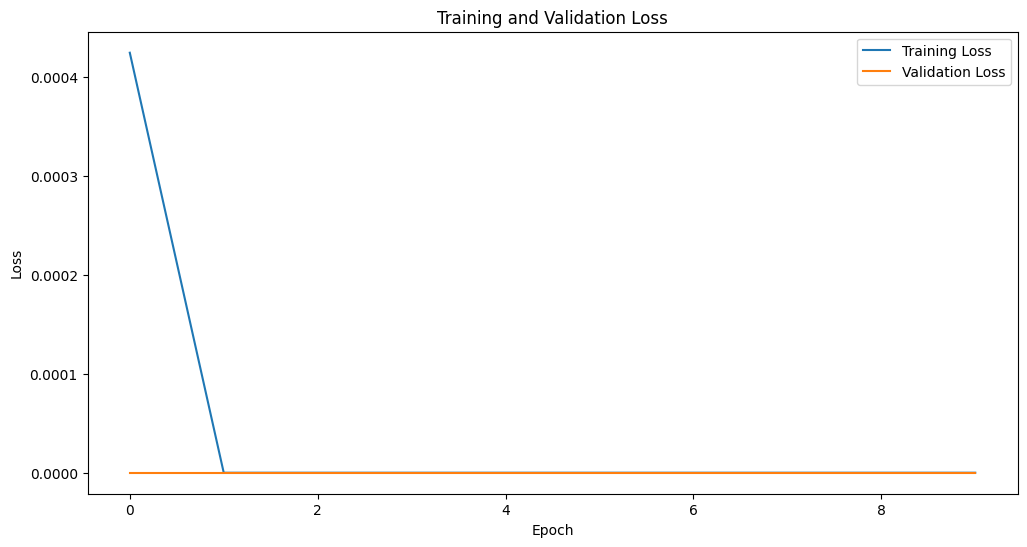

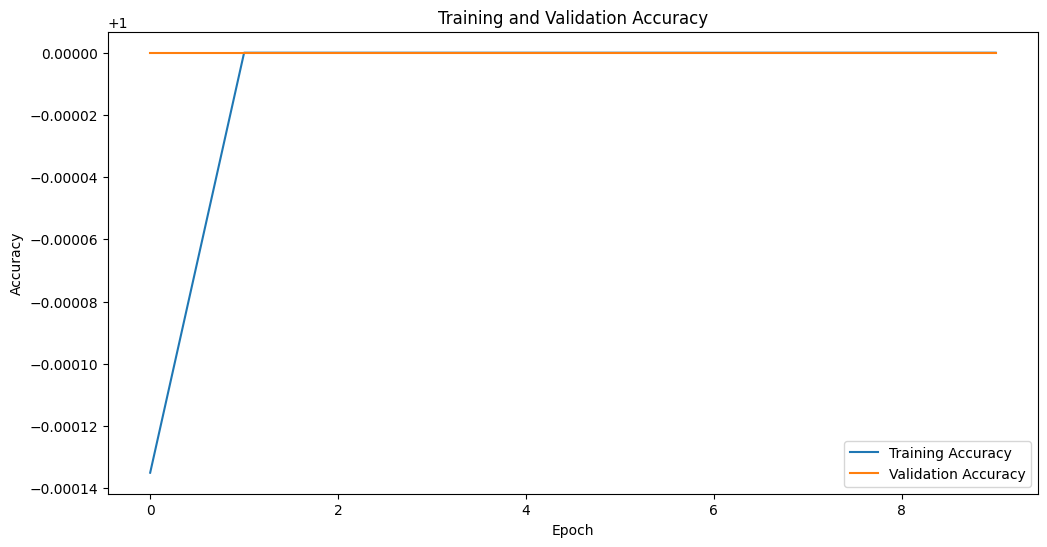

In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/path/to/your/Data.csv'  # Update with the actual file path
data = pd.read_csv(file_path)

# Function to check if a column has only one unique value
def check_single_value_column(column):
    unique_values = data[column].unique()
    if len(unique_values) == 1:
        print(f"Column '{column}' has only one unique value: {unique_values[0]}. Skipping training for this column.")
        return True
    return False

# Define the columns to check
columns_to_check = ['model_type', 'maneuvering_direction', 'fault']

# Iterate through columns and only proceed with training if multiple labels exist
for target_column in columns_to_check:
    if not check_single_value_column(target_column):
        # Extract features and labels
        audio_features = data['audio_features'].apply(eval).tolist()
        labels = data[target_column]

        # One-hot encode labels for multi-class classification
        labels = pd.get_dummies(labels).values

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(audio_features, labels, test_size=0.2, random_state=42)

        print(f"Training and testing on column '{target_column}'")
        print(f"Training data shape: {np.array(X_train).shape}, Labels shape: {np.array(y_train).shape}")
        print(f"Testing data shape: {np.array(X_test).shape}, Labels shape: {np.array(y_test).shape}")
